In [65]:
# package import

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
# import pandas as pd
# import time
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
%matplotlib inline
plt.style.use('bmh')


In [66]:
import numpy as np
print(np.__version__)


1.21.6


In [67]:
# Load in the data
trainDataFull = np.load('k49-train-imgs.npz')
trainLabelFull = np.load('k49-train-labels.npz')
testData = np.load('k49-test-imgs.npz')
testLabel = np.load('k49-test-labels.npz')

X_trainFull = trainDataFull['arr_0']
t_trainFull = trainLabelFull['arr_0']
X_test = testData['arr_0']
t_test = testLabel['arr_0']

assert X_trainFull.shape == (232365, 28, 28)
assert X_test.shape == (38547, 28, 28)
assert t_trainFull.shape == (232365,)
assert t_test.shape == (38547,)

# 49 classes of character


In [68]:
# Train-Val split and scaling
X_train, X_val, t_train, t_val = train_test_split(
    X_trainFull, t_trainFull, test_size=0.15, random_state=24
)

X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)
X_val = X_val.reshape(X_val.shape[0], 28 * 28)

# scaling
scaler = MinMaxScaler(copy=False)

scaler.fit(X_train)
scaler.fit(X_val)
scaler.fit(X_test)


X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)

print(X_train.shape)

(197510, 28, 28, 1)


In [77]:
# Build a CNN model
# Play with the different parameters to get a decent enough model that doesn't melt your computer
tf.keras.backend.clear_session()
model1 = models.Sequential()

# Convolutional layers
model1.add(layers.Conv2D(32, (7,7), activation='relu', input_shape=(28, 28, 1), padding="same"))
model1.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(layers.MaxPooling2D((2, 2)))

model1.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
model1.add(layers.MaxPooling2D((2, 2)))

# model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
# model1.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))
# model1.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu', padding="same"))

# Dense layers for classification
model1.add(layers.Flatten())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(49, activation='softmax')) # 49 different classes, so final layers has 10 outputs

In [78]:
model1.summary()
print(model1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        1600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0

In [79]:
# Compile and train the model
model1.compile(optimizer='nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            #   loss=tf.keras.losses.CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=True), # Use focal cross entropy if classes imbalanced
              metrics=['accuracy'])

history = model1.fit(X_train, t_train, epochs=30, 
                    validation_data=(X_val, t_val),
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                    patience=10,
                    restore_best_weights=True))

Epoch 1/30
6173/6173 [==============================] - 40s 6ms/step - loss: 0.4660 - accuracy: 0.8778 - val_loss: 0.2656 - val_accuracy: 0.9278
Epoch 2/30
6173/6173 [==============================] - 37s 6ms/step - loss: 0.2180 - accuracy: 0.9402 - val_loss: 0.2101 - val_accuracy: 0.9456
Epoch 3/30
6173/6173 [==============================] - 39s 6ms/step - loss: 0.1790 - accuracy: 0.9508 - val_loss: 0.1988 - val_accuracy: 0.9457
Epoch 4/30
6173/6173 [==============================] - 38s 6ms/step - loss: 0.1542 - accuracy: 0.9567 - val_loss: 0.1996 - val_accuracy: 0.9490
Epoch 5/30
6173/6173 [==============================] - 40s 7ms/step - loss: 0.1406 - accuracy: 0.9609 - val_loss: 0.2000 - val_accuracy: 0.9502
Epoch 6/30
6173/6173 [==============================] - 40s 6ms/step - loss: 0.1302 - accuracy: 0.9640 - val_loss: 0.2119 - val_accuracy: 0.9491
Epoch 7/30
6173/6173 [==============================] - 38s 6ms/step - loss: 0.1209 - accuracy: 0.9666 - val_loss: 0.2119 - val_ac

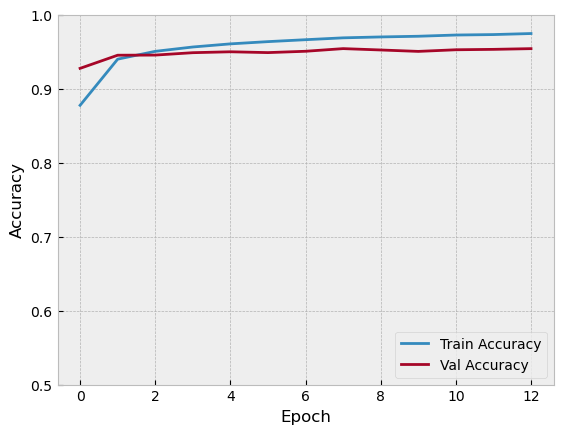

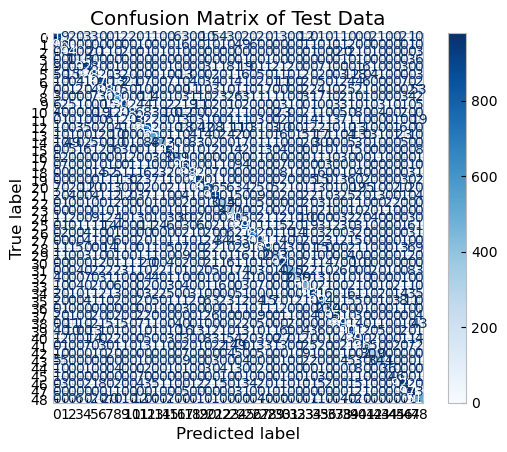

1205/1205 - 2s - loss: 0.3798 - accuracy: 0.9044


In [80]:
# Evaluation
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# Get predictions
predTest = model1.predict(X_test)
predClasses = np.argmax(predTest, axis=1)  

# Confusion matrix
cm = confusion_matrix(t_test, predClasses)

labelNums = np.arange(49)
# Confusion matrix display
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelNums)

# Plot the test confusion matrix
display.plot(cmap='Blues')
plt.title('Confusion Matrix of Test Data')
plt.show()

test_loss, test_acc = model1.evaluate(X_test,  t_test, verbose=2)


In [62]:
print(t_test[0:10])
# tf.keras.backend.image_data_format()

[19 23 10 31 26 12 24  9 24  8]


In [64]:
foo = np.arange(49)
print(foo)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]
